In [192]:
import pandas as pd
from core.repository import load_financial
from base.timeutil import YearMonth
import sqlite3
from core.repository.maria.conn import maria_home

db_file = "analysis.db"

try:
    layer1 = pd.read_sql("select * from layer1", sqlite3.connect(db_file))
except:
    print("Fetching month chart...")
    month_chart = pd.read_sql("""
        select month_chart.*, stock.name, stock.exchange from month_chart
        join stock on month_chart.code = stock.code;
    """, maria_home())
    print("Building layer1...")

    begin = YearMonth(2002, 4)
    end = YearMonth(2023, 4)

    month_chart["년월"] = [YearMonth.from_date(d) for d in month_chart["date"]]
    layer1 = pd.DataFrame()
    for ym1, ym2 in [(row.iloc[0], row.iloc[1]) for row in pd.Series(begin.to(end)).rolling(2) if len(row) == 2]:
        print(f"\r{ym1} {ym2}", end="\r")
        df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
        df2 = month_chart[month_chart["년월"] == ym2].set_index("code")
        df1 = df1[df1["val_last"] >= 1000_0000]
        df2.loc[df2["val_last"] == 0, "close"] = df2[df2["val_last"] == 0]["close"] / 5

        df = pd.DataFrame({
            "종목명": df1["name"],
            "거래소": df1["exchange"],
            "매수년월": str(ym1),
            "매도년월": str(ym2),
            "시가총액": df1["cap"],
            "매수일": df1["date"],
            "매수가": df1["close"],
            "거래량": df1["vol"],
            "거래대금": df1["val"],
            "전월수익률": df1["close"] / df1["open"] - 1
        })

        df["매도가"] = df2["close"]
        df["매도일"] = df2["date"]
        df["수익률"] = df["매도가"] / df["매수가"] - 1
        # 재무데이터 조인하여 layer1에 반영
        fn = load_financial(ym1.year, ym1.month)
        layer1 = pd.concat([layer1, df.join(fn)])

    layer1 = layer1.reset_index()
    layer1["확정실적"] = layer1["확정실적"].apply(str)
    layer1.to_sql("layer1", sqlite3.connect(db_file), if_exists="replace", index=False)

layer1

Fetching month chart...
Building layer1...


,code,종목명,거래소,매수년월,매도년월,시가총액,매수일,매수가,거래량,거래대금,...,E_QoQ,R/A_QoQ,GP/A_QoQ,O/A_QoQ,E/A_QoQ,R/EQ_QoQ,GP/EQ_QoQ,O/EQ_QoQ,E/EQ_QoQ,확정실적
0,060310,3S,코스닥,2002-04,2002-05,14328000000,2002-04-30,2604,1480725,12071273140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
1,006840,AK홀딩스,유가증권,2002-04,2002-05,108300000000,2002-04-30,11302,706504,15311799550,...,2.151386,0.039735,0.013609,0.007998,0.012766,0.081359,0.027205,0.015848,0.025052,2001-4Q
2,054620,APS,코스닥,2002-04,2002-05,20934600000,2002-04-30,6162,3623832,41050604910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
3,001460,BYC,유가증권,2002-04,2002-05,38413822500,2002-04-30,61500,73712,5506711000,...,-0.608231,-0.011676,-0.001393,0.003334,-0.017559,-0.014840,-0.001662,0.004425,-0.023219,2001-4Q
4,001040,CJ,유가증권,2002-04,2002-05,1250135164800,2002-04-30,28006,4513180,263372467300,...,1.157134,0.248107,0.137269,0.058049,0.032612,0.635466,0.395791,0.181644,0.106711,2001-4Q
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389473,189980,흥국에프엔비,코스닥,2023-03,2023-04,109174889440,2023-03-31,2720,4793251,13321516235,...,0.349857,-0.040107,-0.014214,-0.004336,-0.003231,0.021607,0.007003,0.005584,0.006135,2022-3Q
389474,000540,흥국화재,유가증권,2023-03,2023-04,204291611100,2023-03-31,3180,1993371,6854371810,...,NaN,0.005376,NaN,0.001088,NaN,0.380950,NaN,0.033848,NaN,2022-3Q
389475,003280,흥아해운,유가증권,2023-03,2023-04,331545935721,2023-03-31,1379,3590072,5045791486,...,8.103269,0.085515,0.043808,0.042733,0.018525,0.229167,0.108547,0.102940,0.046502,2022-3Q
389476,037440,희림,코스닥,2023-03,2023-04,126972972000,2023-03-31,9120,15461656,152143635870,...,2.517199,-0.004923,0.011450,0.005833,0.010255,-0.045885,0.030324,0.016097,0.028984,2022-3Q


In [225]:

import numpy as np

layer2 = layer1.rename(
    columns={
        "시가총액": "P",
        "거래대금": "TV",
        "자산총계": "A",
        "자본총계": "EQ",

        "매출액": "R",
        "매출총이익": "GP",
        "영업이익": "O",
        "당기순이익": "E",
    }
)

factors = [
    "R_QoQ",
    "GP_QoQ",
    "O_QoQ",
    "E_QoQ",

    "R/A_QoQ",
    "GP/A_QoQ",
    "O/A_QoQ",
    "E/A_QoQ",

    "R/EQ_QoQ",
    "GP/EQ_QoQ",
    "O/EQ_QoQ",
    "E/EQ_QoQ",

    "BIS",
    "BIS_QoQ",
    "전월수익률"
]

for pos in ["R", "GP", "O", "E", "EQ"]:
    factor = f"{pos}/P"
    factors.append(factor)
    layer2[factor] = layer2[pos] / layer2["P"]
    layer2.loc[layer2[pos] <= 0, factor] = np.nan

for neg in ["A", "EQ"]:
    for pos in ["R", "GP", "O", "E"]:
        factor = f"{pos}/{neg}"
        factors.append(factor)
        layer2[factor] = layer2[pos] / layer2[neg]
        layer2.loc[layer2[neg] <= 0, factor] = np.nan

factors.append("P")

layer2["TV/P"] = layer2["TV"] / layer2["P"]
factors.append("TV/P")

result = pd.DataFrame()
yms = layer2["매수년월"].unique()

recipes = {
    "recipe": {
        "P": -8,
        "GP/P": 4,
        "EQ/P": 4,

        "R_QoQ": 1,
        "GP_QoQ": 1,
        "O_QoQ": 1,
        "E_QoQ": 1,

        "R/A_QoQ": 1,
        "GP/A_QoQ": 1,
        "O/A_QoQ": 1,
        "E/A_QoQ": 1
    },
    "recipe0": {
        "P": -8,

        "GP/P": 3,
        "EQ/P": 3,
        "O/P": 3,

        "R_QoQ": 1,
        "GP_QoQ": 1,
        "O_QoQ": 1,
        "E_QoQ": 1,

        "R/A_QoQ": 1,
        "GP/A_QoQ": 1,
        "O/A_QoQ": 1,
        "E/A_QoQ": 1
    },
    "벨류": {
        "GP/P": 1,
        "EQ/P": 1,
    },
    "벨류0": {
        "GP/P": 1,
        "EQ/P": 1,
        "O/P": 1
    },
    "성장": {
        "R_QoQ": 1,
        "GP_QoQ": 1,
        "O_QoQ": 1,
        "E_QoQ": 1,

        "R/A_QoQ": 1,
        "GP/A_QoQ": 1,
        "O/A_QoQ": 1,
        "E/A_QoQ": 1
    },
    "공매도0": {
        "벨류": -1,
        "TV/P": 1,
    }
}

print(pd.DataFrame(recipes))

for ym in yms:
    df = layer2[layer2["매수년월"] == ym].copy()
    for factor in factors:
        print(f"\r{ym}", end="")
        colname_pct = f"{factor}_pct"
        df[colname_pct] = np.ceil(df[factor].rank(method="min", pct=True) * 100)

    for title, recipe in recipes.items():
        # 1. 레시피를 구성하는 개별 팩터 분위(percentile) * 가중치의 총합을 구함
        sv = sum([df[f"{k}_pct"] * w if w > 0 else (1 - df[f"{k}_pct"]) * abs(w) for k, w in recipe.items()])
        # 2. 위의 시리즈에 가중치의 총합을 나눈다 => 0~1 사이 값으로 일반화됨
        df[title] = sv / sum([abs(w) for w in recipe.values()])
        df[f"{title}_pct"] = np.ceil(df[title].rank(method="min", pct=True) * 100)

    result = pd.concat([result, df])

factors = list(recipes.keys()) + factors
result

          recipe  recipe0   벨류  벨류0   성장  공매도0
P           -8.0     -8.0  NaN  NaN  NaN   NaN
GP/P         4.0      3.0  4.0  4.0  NaN   NaN
EQ/P         4.0      3.0  4.0  4.0  NaN   NaN
R_QoQ        1.0      1.0  NaN  NaN  1.0   NaN
GP_QoQ       1.0      1.0  NaN  NaN  1.0   NaN
O_QoQ        1.0      1.0  NaN  NaN  1.0   NaN
E_QoQ        1.0      1.0  NaN  NaN  1.0   NaN
R/A_QoQ      1.0      1.0  NaN  NaN  1.0   NaN
GP/A_QoQ     1.0      1.0  NaN  NaN  1.0   NaN
O/A_QoQ      1.0      1.0  NaN  NaN  1.0   NaN
E/A_QoQ      1.0      1.0  NaN  NaN  1.0   NaN
O/P          NaN      3.0  NaN  4.0  NaN   NaN
벨류           NaN      NaN  NaN  NaN  NaN  -1.0
TV/P         NaN      NaN  NaN  NaN  NaN   1.0
2023-03

,code,종목명,거래소,매수년월,매도년월,P,매수일,매수가,거래량,TV,...,recipe0,recipe0_pct,벨류,벨류_pct,벨류0,벨류0_pct,성장,성장_pct,공매도0,공매도0_pct
0,060310,3S,코스닥,2002-04,2002-05,14328000000,2002-04-30,2604,1480725,12071273140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,006840,AK홀딩스,유가증권,2002-04,2002-05,108300000000,2002-04-30,11302,706504,15311799550,...,16.00,40.0,54.5,55.0,50.333333,47.0,72.375,83.0,-18.0,28.0
2,054620,APS,코스닥,2002-04,2002-05,20934600000,2002-04-30,6162,3623832,41050604910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001460,BYC,유가증권,2002-04,2002-05,38413822500,2002-04-30,61500,73712,5506711000,...,30.84,74.0,93.0,96.0,87.666667,92.0,49.750,49.0,-38.5,3.0
4,001040,CJ,유가증권,2002-04,2002-05,1250135164800,2002-04-30,28006,4513180,263372467300,...,23.12,57.0,66.5,71.0,68.000000,70.0,91.750,100.0,-20.5,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389473,189980,흥국에프엔비,코스닥,2023-03,2023-04,109174889440,2023-03-31,2720,4793251,13321516235,...,19.84,54.0,51.5,50.0,52.000000,48.0,45.500,43.0,1.5,51.0
389474,000540,흥국화재,유가증권,2023-03,2023-04,204291611100,2023-03-31,3180,1993371,6854371810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
389475,003280,흥아해운,유가증권,2023-03,2023-04,331545935721,2023-03-31,1379,3590072,5045791486,...,16.40,45.0,21.5,16.0,27.333333,17.0,95.500,100.0,-5.5,41.0
389476,037440,희림,코스닥,2023-03,2023-04,126972972000,2023-03-31,9120,15461656,152143635870,...,21.56,59.0,37.0,33.0,40.000000,32.0,69.375,76.0,30.0,88.0


36/36
2002-04 2023-04
          recipe  recipe0   벨류  벨류0   성장  공매도0
P           -8.0     -8.0  NaN  NaN  NaN   NaN
GP/P         4.0      3.0  4.0  4.0  NaN   NaN
EQ/P         4.0      3.0  4.0  4.0  NaN   NaN
R_QoQ        1.0      1.0  NaN  NaN  1.0   NaN
GP_QoQ       1.0      1.0  NaN  NaN  1.0   NaN
O_QoQ        1.0      1.0  NaN  NaN  1.0   NaN
E_QoQ        1.0      1.0  NaN  NaN  1.0   NaN
R/A_QoQ      1.0      1.0  NaN  NaN  1.0   NaN
GP/A_QoQ     1.0      1.0  NaN  NaN  1.0   NaN
O/A_QoQ      1.0      1.0  NaN  NaN  1.0   NaN
E/A_QoQ      1.0      1.0  NaN  NaN  1.0   NaN
O/P          NaN      3.0  NaN  4.0  NaN   NaN
벨류           NaN      NaN  NaN  NaN  NaN  -1.0
TV/P         NaN      NaN  NaN  NaN  NaN   1.0


,spearman,h3,h5,h10,t3,t5,t10,mdd5,h3-t3,h10-t10,h3-t3+mdd3,h10-t10+mdd10,mean,median,strength
factor,,,,,,,,,,,,,,,
벨류,0.918320,0.266139,0.256549,0.244106,-0.142838,-0.145851,-0.088866,-0.568801,0.408977,0.332971,-0.174070,-0.214015,0.107112,0.116516,0.234716
recipe,0.958212,0.503873,0.480015,0.434409,-0.137254,-0.120046,-0.090349,-0.507538,0.641127,0.524757,0.139442,0.029829,0.113528,0.076031,0.210394
EQ/P,0.913987,0.208284,0.212163,0.207532,-0.125135,-0.109258,-0.076579,-0.544720,0.333419,0.284111,-0.209356,-0.261284,0.092134,0.107169,0.185837
GP_QoQ,0.853729,0.125834,0.129742,0.145948,-0.122626,-0.109006,-0.062387,-0.629847,0.248460,0.208335,-0.363786,-0.398679,0.094661,0.102098,0.171393
E/A,0.109427,0.013847,0.051087,0.067802,-0.165310,-0.117396,-0.051952,-0.654373,0.179158,0.119754,-0.512710,-0.504585,0.094785,0.105013,0.169348
E/EQ_QoQ,0.780606,0.021464,0.062237,0.114875,-0.145466,-0.103503,-0.065406,-0.700984,0.166931,0.180281,-0.619090,-0.460837,0.094162,0.101279,0.168909
E/A_QoQ,0.798668,0.030492,0.083962,0.128821,-0.130870,-0.102145,-0.062751,-0.693207,0.161362,0.191572,-0.602638,-0.447866,0.093981,0.098542,0.164895
recipe0,0.951095,0.474630,0.475962,0.407130,-0.125171,-0.098630,-0.063670,-0.532395,0.599801,0.470800,0.141092,-0.063861,0.119085,0.080832,0.162299
GP/P,0.914503,0.236246,0.220530,0.217202,-0.081450,-0.076846,-0.069360,-0.580363,0.317696,0.286561,-0.277389,-0.259975,0.105180,0.113633,0.146206


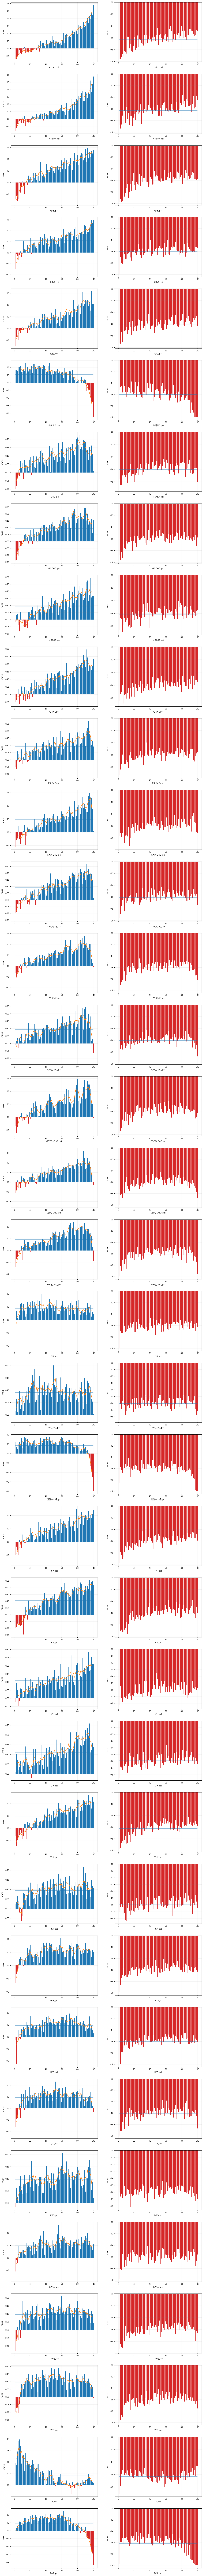

In [226]:
import matplotlib.pyplot as plt
from core.base.quantutil import cagr, mdd
from base.timeutil import YearMonth
from datetime import date

# plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
plt.rcParams['agg.path.chunksize'] = 10_000

# target_factors = factors
target_factors = list(recipes.keys())
fig, subplots = plt.subplots(len(target_factors), 2)
fig.set_figwidth(16), fig.set_figheight(6 * len(target_factors))

summary = pd.DataFrame()
for i in range(len(target_factors)):
    print(f"\r{i + 1}/{len(target_factors)}", end="")
    factor = factors[i]
    colname_pct = f"{factor}_pct"
    percentiles = sorted(set(result[colname_pct].dropna()))
    mean_by_pct = []
    cagr_by_pct = []
    mdd_by_pct = []
    for pct in percentiles:
        by_pct = result[result[colname_pct] == pct]
        return_by_ym = by_pct.groupby("매도년월")["수익률"].mean()
        begin = YearMonth.from_string(by_pct["매수년월"].min())
        cumprod = (return_by_ym + 1).cumprod()
        last = cumprod[-1]
        mean_by_pct.append(return_by_ym.mean())
        cagr_by_pct.append(cagr(1, last, by_pct["매도년월"].unique().size / 12))
        dates = [date(int(s.split("-")[0]), int(s.split("-")[1]), 1) for s in return_by_ym.index]
        mdd_by_pct.append(mdd(dates, cumprod.values)[0])

    ax1, ax2 = subplots[i][0], subplots[i][1]

    cagr_by_pct_series = pd.Series(cagr_by_pct)
    mdd_by_pct_series = pd.Series(mdd_by_pct)

    ax1.set_xlabel(colname_pct)
    ax1.set_ylabel("CAGR")
    ax1.grid(True)
    ax1.bar(percentiles, cagr_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in cagr_by_pct])
    ax1.plot(percentiles, [cagr_by_pct_series.mean() for _ in percentiles], alpha=0.5)
    ax1.plot(percentiles, cagr_by_pct_series.rolling(5, center=True).mean())

    ax2.set_xlabel(colname_pct)
    ax2.set_ylabel("MDD")
    ax2.grid(True)
    ax2.bar(percentiles, mdd_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in mdd_by_pct])
    ax2.plot(percentiles, [mdd_by_pct_series.mean() for _ in percentiles], alpha=0.5)

    corr = pd.DataFrame({colname_pct: percentiles, "cagr": cagr_by_pct}).corr(method="spearman")
    cagr_by_pct_desc = cagr_by_pct_series[cagr_by_pct_series.index.sort_values(ascending=False)]
    mdd_by_pct_desc = mdd_by_pct_series[mdd_by_pct_series.index.sort_values(ascending=False)]
    summary = pd.concat([
        summary,
        pd.Series({
            "spearman": corr[colname_pct]["cagr"],

            "h3": cagr_by_pct_desc.head(3).mean(),
            "h5": cagr_by_pct_desc.head(5).mean(),
            "h10": cagr_by_pct_desc.head(10).mean(),

            "t3": cagr_by_pct_desc.tail(3).mean(),
            "t5": cagr_by_pct_desc.tail(5).mean(),
            "t10": cagr_by_pct_desc.tail(10).mean(),

            "mdd5": mdd_by_pct_desc.head(5).mean(),

            "h3-t3": cagr_by_pct_desc.head(3).mean() - cagr_by_pct_desc.tail(3).mean(),
            "h10-t10": cagr_by_pct_desc.head(10).mean() - cagr_by_pct_desc.tail(10).mean(),

            "h3-t3+mdd3": cagr_by_pct_desc.head(3).mean() - cagr_by_pct_desc.tail(3).mean() + mdd_by_pct_desc.head(
                3).mean(),
            "h10-t10+mdd10": cagr_by_pct_desc.head(10).mean() - cagr_by_pct_desc.tail(10).mean() + mdd_by_pct_desc.head(
                10).mean(),
            "mean": cagr_by_pct_desc.mean(),
            "median": cagr_by_pct_desc.median(),
        }).to_frame(factor).T
    ])

fig.savefig('test.png', bbox_inches='tight')

print()
print(result["매수년월"].min(), result["매도년월"].max())
print(pd.DataFrame(recipes))

summary.index.name = "factor"
summary.to_sql("sfw", sqlite3.connect(db_file), if_exists="replace")
summary["strength"] = pow(summary["spearman"] * summary["h10"], 2)
summary["strength"] = -(summary["t5"] + summary["t10"])
summary = summary.sort_values("strength", ascending=False)
summary.to_csv("summary.csv")
summary

In [227]:
target_code = "002070"
result[result["code"] == target_code][["종목명", "매도년월", "recipe_pct"]]

,종목명,매도년월,recipe_pct
371,비비안,2002-05,NaN
1284,비비안,2002-06,75.0
2190,비비안,2002-07,70.0
3079,비비안,2002-08,69.0
3983,비비안,2002-09,89.0
...,...,...,...
378026,비비안,2022-12,98.0
380478,비비안,2023-01,98.0
382922,비비안,2023-02,98.0
385387,비비안,2023-03,98.0


In [220]:
from core.base.quantutil import cagr, mdd
from base.timeutil import YearMonth

_key = ["매수년월", "매도년월"]
benchmark = result.groupby(_key)["수익률"].mean()

factor = "recipe"
print(factor)

head = 20
result2 = result.copy()
result2 = result2[~result2["종목명"].str.endswith("홀딩스")]
result2 = result2[~result2["종목명"].str.endswith("지주")]

result2 = result2[result2["TV/P_pct"] > 10]
result2 = result2[result2["R/A_pct"] > 10]
result2 = result2[result2["GP/A_pct"] > 10]
result2 = result2[result2["O/A_pct"] > 10]
result2 = result2[result2["E/A_pct"] > 10]
result2 = result2[result2["R/EQ_pct"] > 10]
result2 = result2[result2["GP/EQ_pct"] > 10]
result2 = result2[result2["O/EQ_pct"] > 10]
result2 = result2[result2["E/EQ_pct"] > 10]

strategy = result2.groupby(_key).apply(
    lambda values: values.sort_values(factor, ascending=False).head(head)["수익률"].mean())
strategy = pd.Series(strategy, index=benchmark.index).fillna(0)

revisions = pd.DataFrame({
    "벤치마크 수익률": benchmark,
    "전략 수익률": strategy,
    "성능": round(strategy - benchmark, 2),
    "벤치마크 누적수익률": (benchmark + 1).cumprod(),
    "전략 누적수익률": (strategy + 1).cumprod()
})


def str_to_ym(_s: str):
    _sp = _s.split("-")
    return YearMonth(int(_sp[0]), int(_sp[1]))


begin = str_to_ym(revisions.index[0][0])
end = str_to_ym(revisions.index[-1][-1])
years = (end.value() - begin.value()) / 12

summary = pd.DataFrame({
    "CAGR": [cagr(1, revisions["전략 누적수익률"][-1], years), cagr(1, revisions["벤치마크 누적수익률"][-1], years)],
    "MDD": [mdd([i2 for _, i2 in revisions.index], revisions["전략 누적수익률"]),
            mdd([i2 for _, i2 in revisions.index], revisions["벤치마크 누적수익률"])],
    "Mean": [revisions["전략 수익률"].mean(), revisions["벤치마크 수익률"].mean()]
}, index=["전략", "벤치마크"])
print(summary)

result3 = result2.groupby(_key).apply(
    lambda x: x.sort_values(factor, ascending=False).head(head).sort_values("수익률", ascending=False))[
    ["code", "종목명", "수익률", "거래소", "매수일", "매도일", "매수가", "매도가", f"{factor}_pct"]]
result3.to_csv("result3-2.csv")
result3

recipe
          CAGR                                         MDD      Mean
전략    0.631500  (-0.48402841744631775, (2007-09, 2008-10))  0.045761
벤치마크  0.097266   (-0.5658884439667557, (2007-07, 2008-10))  0.010084


code    종목명       수익률   거래소         매수일         매도일  \
매수년월    매도년월                                                                    
2002-04 2002-05 263     012510  더존비즈온  4.506840  유가증권  2002-04-30  2002-05-31   
                114     005610  SPC삼립  0.219468  유가증권  2002-04-30  2002-05-31   
                488     005390   신성통상  0.128617  유가증권  2002-04-30  2002-05-31   
                648     006490   인스코비  0.069155  유가증권  2002-04-30  2002-05-31   
                377     003960   사조대림  0.060615  유가증권  2002-04-30  2002-05-31   
...                        ...    ...       ...   ...         ...         ...   
2023-03 2023-04 388370  044780  에이치케이 -0.076692   코스닥  2023-03-31  2023-04-28   
                389145  225590  패션플랫폼 -0.101307   코스닥  2023-03-31  2023-04-28   
                387205  123700    SJM -0.113548  유가증권  2023-03-31  2023-04-28   
                388106  115570  스타플렉스 -0.119510   코스닥  2023-03-31  2023-04-28   
                388399  054940  엑사이엔씨 -0.169243   코스닥  2023-03-31  2023-04-28   

                          매수가      매도가  recipe_pct  
매수년월    매도년월                                        
2002-04 2002-05 263      5775  31802.0        99.0  
                114     16663  20320.0        99.0  
                488       311    351.0        99.0  
                648      3456   3695.0        97.0  
                377     38621  40962.0       100.0  
...                       ...      ...         ...  
2023-03 2023-04 388370   1995   1842.0       100.0  
                389145   1530   1375.0       100.0  
                387205   3875   3435.0       100.0  
                388106   4895   4310.0        99.0  
                388399   1229   1021.0       100.0  

[5040 rows x 9 columns]

,총수익률,size,평균수익률
count_std,,,
0.0,31.481798,97,0.036201
1.0,412.203689,114,0.054240
2.0,34.528967,101,0.035689
3.0,6.951969,66,0.029815
4.0,4.939114,54,0.030019
5.0,1.458243,25,0.015204
6.0,1.948927,15,0.045490
7.0,2.002749,16,0.044363
8.0,1.215760,11,0.017920


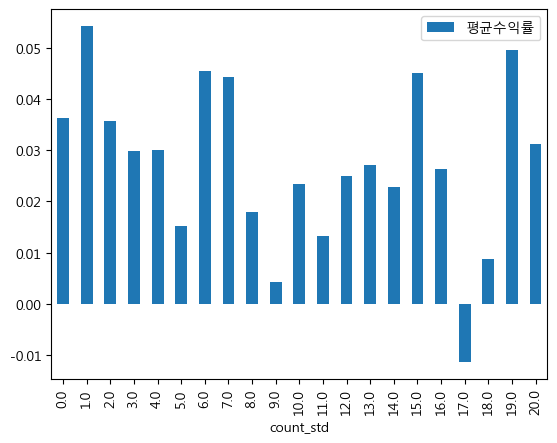

In [197]:
result3.loc[result3["수익률"] == -1, "수익률"] = -0.5
# 종목별 최종수익률 계산
total = result3.groupby("code")["수익률"].apply(lambda x: (x + 1).prod()).rename("최종수익률")
# 종목별 선정 횟수 계산
count = result3.groupby("code").size().rename("count")
# 종목별 선정 횟수 표준화
count_std = ((count - count.min()) / (count.max() - count.min()) * 20).rename("count_std")
count_std = np.ceil(count_std)

perform_by_count = pd.concat([
    count,
    count_std,
    ((total / 1) ** (1 / count) - 1).rename("평균수익률")
], axis=1)

total = perform_by_count.groupby("count_std")["평균수익률"].apply(lambda x: (x + 1).prod()).rename("총수익률")
size = perform_by_count.groupby("count_std").size().rename("size")

df = pd.concat([
    total,
    size,
    ((total / 1) ** (1 / size) - 1).rename("평균수익률")
], axis=1)
df.plot(kind='bar', y='평균수익률')
df

In [198]:
pd.concat(
    [
        revisions,
        revisions["벤치마크 수익률"].rolling(12).apply(lambda x: round((x + 1).prod() - 1, 2)).rename("벤치마크12"),
        revisions["성능"].rolling(12).apply(lambda x: round((x + 1).prod() - 1, 2)).rename("성능12")
    ],
    axis=1
)

,,벤치마크 수익률,전략 수익률,성능,벤치마크 누적수익률,전략 누적수익률,벤치마크12,성능12
매수년월,매도년월,,,,,,,
2002-04,2002-05,-0.047674,0.235074,0.28,0.952326,1.235074,NaN,NaN
2002-05,2002-06,-0.107912,-0.108834,-0.00,0.849559,1.100656,NaN,NaN
2002-06,2002-07,-0.007441,0.049988,0.06,0.843237,1.155675,NaN,NaN
2002-07,2002-08,0.033922,0.073867,0.04,0.871842,1.241041,NaN,NaN
2002-08,2002-09,-0.156468,-0.016984,0.14,0.735427,1.219964,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-11,2022-12,-0.057066,-0.077308,-0.02,6.368350,21235.837493,-0.24,0.44
2022-12,2023-01,0.091604,0.122614,0.03,6.951717,23839.648075,-0.08,0.36
2023-01,2023-02,0.014356,0.028974,0.01,7.051514,24530.382303,-0.09,0.35


전체 개월 수       252.000000
초과수익 개월 수     179.000000
누적 성능        3960.056623
dtype: float64

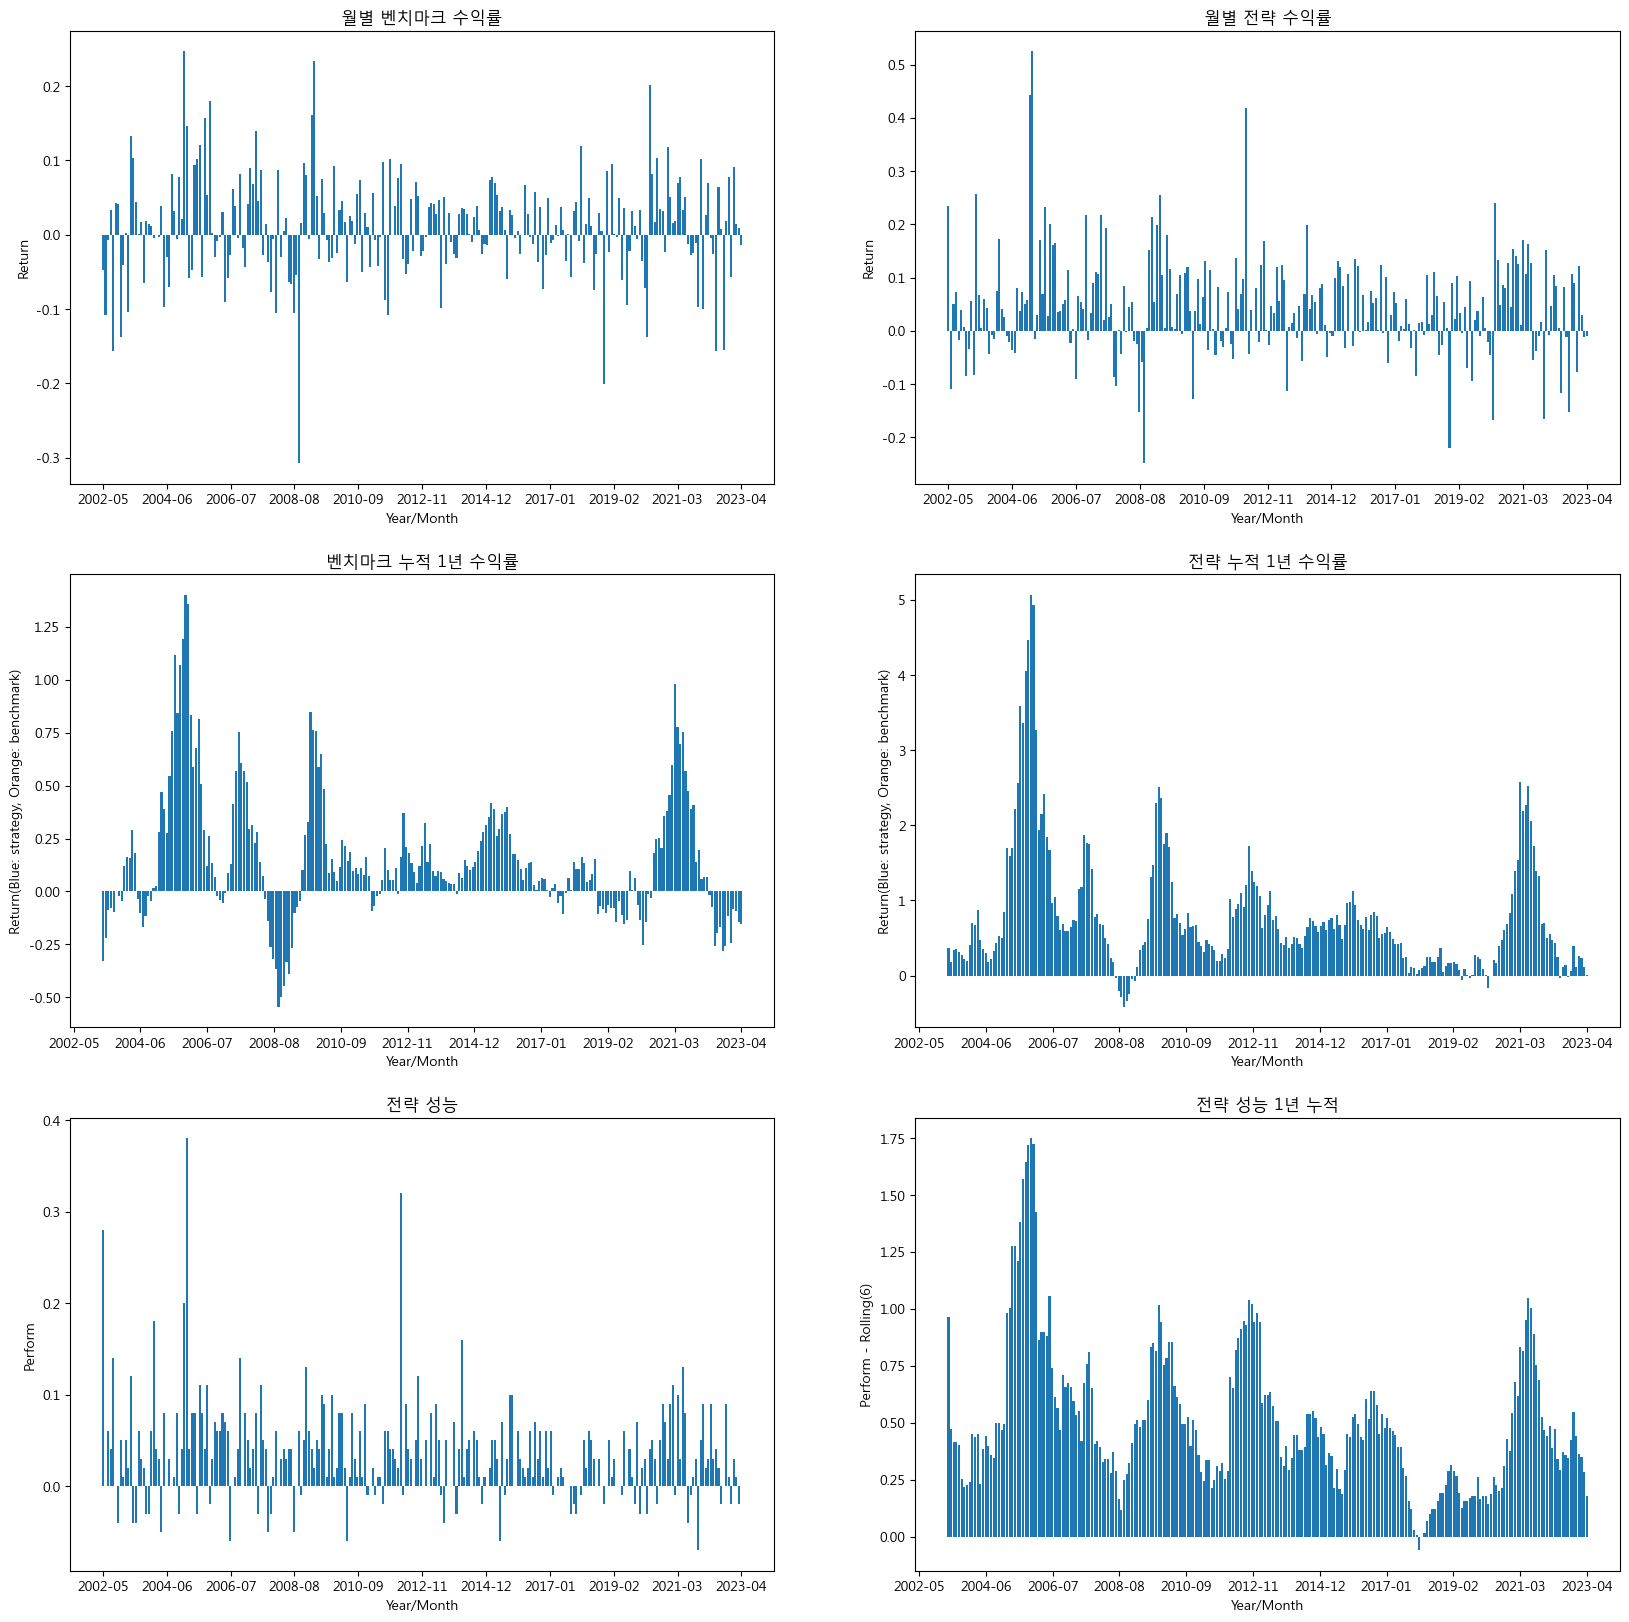

In [199]:
import numpy as np
import matplotlib.pyplot as plt

months = [i for _, i in strategy.index]

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

xticks = [1 * i / 10 for i in range(10)] + [1]

ax1.set_title(f"월별 벤치마크 수익률")
ax1.set_xlabel("Year/Month")
ax1.set_ylabel("Return")
ax1.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax1.bar(months, revisions["벤치마크 수익률"])

ax2.set_title("월별 전략 수익률")
ax2.set_xlabel("Year/Month")
ax2.set_ylabel("Return")
ax2.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax2.bar(months, revisions["전략 수익률"])

ax3.set_title(f"벤치마크 누적 1년 수익률")
ax3.set_xlabel("Year/Month")
ax3.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax3.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax3.bar(months, revisions["벤치마크 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1))

ax4.set_title("전략 누적 1년 수익률")
ax4.set_xlabel("Year/Month")
ax4.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax4.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax4.bar(months, revisions["전략 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1))

ax5.set_title("전략 성능")
ax5.set_xlabel("Year/Month"), ax5.set_ylabel("Perform")
ax5.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax5.bar(months, revisions["성능"])

ax6.set_title(f"전략 성능 1년 누적")
ax6.set_xlabel("Year/Month")
ax6.set_ylabel(f"Perform - Rolling({6})")
ax6.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax6.bar(months, revisions["성능"].rolling(12).apply(lambda x: (x + 1).prod() - 1))

pd.Series({
    "전체 개월 수": len(revisions),
    "초과수익 개월 수": len(revisions[revisions["성능"] > 0]),
    "누적 성능": (revisions["성능"] + 1).prod() - 1,
})